In [1]:
# Core
import numpy as np
import pandas as pd

# Modeling
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Utils
import joblib
import warnings; warnings.filterwarnings("ignore")



In [2]:
# Try common paths (edit if needed)
df = pd.read_csv('/kaggle/input/cleaned-airbnb-data/cleaned_airbnb_data.csv')
df.head()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19 00:00:00,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21 00:00:00,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,No Review,0.00,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05 00:00:00,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19 00:00:00,0.10,1,0


In [3]:
df.info()
df.describe(include='all').T.head(20)

# Target distribution (optional peek)
df['price'].describe(), df['price'].quantile([.01,.99])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45887 entries, 0 to 45886
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              45887 non-null  int64  
 1   name                            45887 non-null  object 
 2   host_id                         45887 non-null  int64  
 3   host_name                       45887 non-null  object 
 4   neighbourhood_group             45887 non-null  object 
 5   neighbourhood                   45887 non-null  object 
 6   latitude                        45887 non-null  float64
 7   longitude                       45887 non-null  float64
 8   room_type                       45887 non-null  object 
 9   price                           45887 non-null  int64  
 10  minimum_nights                  45887 non-null  int64  
 11  number_of_reviews               45887 non-null  int64  
 12  last_review                     

(count    45887.000000
 mean       119.970907
 std         68.145438
 min          0.000000
 25%         65.000000
 50%        100.000000
 75%        159.000000
 max        334.000000
 Name: price, dtype: float64,
 0.01     30.0
 0.99    300.0
 Name: price, dtype: float64)

In [4]:
q1, q99 = df['price'].quantile([0.01, 0.99])
df = df[(df['price'] >= q1) & (df['price'] <= q99)].copy()
df.shape


(45100, 16)

In [5]:
target = 'price'

categorical = [
    'room_type',
    'neighbourhood_group',   # Borough
    # 'neighbourhood',       # optional: many levels → increases OHE width
]

numeric = [
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365',
    'latitude',
    'longitude'
]

# Keep only needed columns
X = df[categorical + numeric].copy()
y = df[target].astype(float)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((36080, 9), (9020, 9))

In [7]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical),
        ("num", StandardScaler(), numeric),
    ],
    remainder="drop"
)


In [8]:
def evaluate(model, X_tr, y_tr, X_te, y_te, name="Model"):
    pred = model.predict(X_te)
    mae  = mean_absolute_error(y_te, pred)
    rmse = mean_squared_error(y_te, pred, squared=False)
    r2   = r2_score(y_te, pred)
    print(f"{name:28s} | MAE: {mae:7.2f} | RMSE: {rmse:7.2f} | R²: {r2:5.3f}")
    return {"model":name, "MAE":mae, "RMSE":rmse, "R2":r2}

models = {
    "Linear": Pipeline([("prep", preprocess), ("model", LinearRegression())]),
    "Ridge":  Pipeline([("prep", preprocess), ("model", Ridge(alpha=1.0))]),
    "Lasso":  Pipeline([("prep", preprocess), ("model", Lasso(alpha=0.001, max_iter=10000))]),
    "RandomForest": Pipeline([("prep", preprocess), ("model", RandomForestRegressor(
        n_estimators=300, max_depth=None, n_jobs=-1, random_state=42))]),
    "GBM": Pipeline([("prep", preprocess), ("model", GradientBoostingRegressor(random_state=42))]),
}

scores = []
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    scores.append(evaluate(pipe, X_train, y_train, X_test, y_test, name))

pd.DataFrame(scores).sort_values("RMSE")


Linear                       | MAE:   35.46 | RMSE:   47.87 | R²: 0.476
Ridge                        | MAE:   35.46 | RMSE:   47.87 | R²: 0.476
Lasso                        | MAE:   35.46 | RMSE:   47.87 | R²: 0.476
RandomForest                 | MAE:   31.39 | RMSE:   43.75 | R²: 0.562
GBM                          | MAE:   31.98 | RMSE:   43.99 | R²: 0.558


,model,MAE,RMSE,R2
3,RandomForest,31.391832,43.750784,0.562480
4,GBM,31.977903,43.994834,0.557586
2,Lasso,35.462756,47.868188,0.476255
1,Ridge,35.462728,47.868218,0.476254
0,Linear,35.464118,47.868338,0.476252


In [9]:
best_pipe = models["RandomForest"]  # pick the best from the table above
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rmse = -cross_val_score(best_pipe, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1)
print("CV RMSE:", cv_rmse.mean().round(2), "±", cv_rmse.std().round(2))


CV RMSE: 43.1 ± 0.57


In [10]:
from sklearn.model_selection import RandomizedSearchCV

rf = Pipeline([("prep", preprocess),
               ("model", RandomForestRegressor(random_state=42, n_jobs=-1))])

param_dist = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [None, 10, 20, 40],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
}

rs = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=20,
    scoring="neg_root_mean_squared_error", cv=3, n_jobs=-1, random_state=42
)
rs.fit(X_train, y_train)

print("Best params:", rs.best_params_)
best_model = rs.best_estimator_
_ = evaluate(best_model, X_train, y_train, X_test, y_test, "RandomForest (Tuned)")


Best params: {'model__n_estimators': 600, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_depth': 20}
RandomForest (Tuned)         | MAE:   31.03 | RMSE:   43.32 | R²: 0.571


In [11]:
# Get OHE feature names to map importances
ohe = best_model.named_steps["prep"].named_transformers_["cat"]
num_names = numeric
cat_names = list(ohe.get_feature_names_out(categorical))
all_names = cat_names + num_names

importances = best_model.named_steps["model"].feature_importances_
fi = (pd.DataFrame({"feature": all_names, "importance": importances})
      .sort_values("importance", ascending=False)
      .head(20))
fi


,feature,importance
0,room_type_Entire home/apt,0.480473
14,longitude,0.160353
13,latitude,0.136467
12,availability_365,0.062836
10,reviews_per_month,0.046538
9,number_of_reviews,0.038594
8,minimum_nights,0.037626
11,calculated_host_listings_count,0.023843
5,neighbourhood_group_Manhattan,0.008636
2,room_type_Shared room,0.001868


In [12]:
joblib.dump(best_model, "airbnb_price_model.joblib")
print("Saved → airbnb_price_model.joblib")


Saved → airbnb_price_model.joblib


In [13]:
# Example: take first 5 rows from test set
sample_preds = best_model.predict(X_test.head(5))
pd.DataFrame({
    "pred_price": sample_preds.round(2),
    "actual_price": y_test.head(5).values
})


,pred_price,actual_price
0,74.00,89.0
1,147.18,107.0
2,149.15,130.0
3,117.94,199.0
4,81.83,40.0


In [14]:
importances = best_model.named_steps["model"].feature_importances_
ohe = best_model.named_steps["prep"].named_transformers_["cat"]
cat_names = list(ohe.get_feature_names_out(categorical))
all_names = cat_names + numeric

fi = pd.DataFrame({"feature": all_names, "importance": importances})
fi.sort_values(by="importance", ascending=False).head(15)


,feature,importance
0,room_type_Entire home/apt,0.480473
14,longitude,0.160353
13,latitude,0.136467
12,availability_365,0.062836
10,reviews_per_month,0.046538
9,number_of_reviews,0.038594
8,minimum_nights,0.037626
11,calculated_host_listings_count,0.023843
5,neighbourhood_group_Manhattan,0.008636
2,room_type_Shared room,0.001868


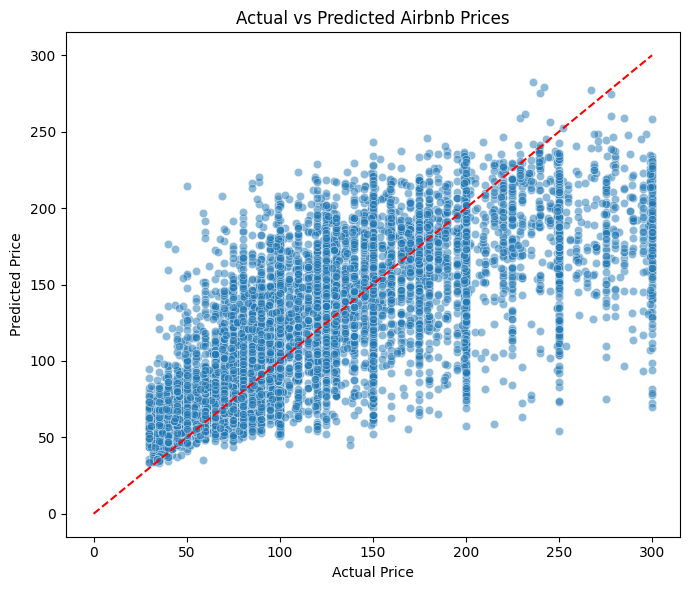

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions
y_pred = best_model.predict(X_test)

plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)

# Add diagonal perfect prediction line
max_val = max(y_test.max(), y_pred.max())
plt.plot([0, max_val], [0, max_val], 'r--')

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Airbnb Prices")
plt.tight_layout()
plt.show()
